<a href="https://colab.research.google.com/github/carloshernangarrido/structural-health-monitoring/blob/main/time_domain_damage_detection_stat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Damage identification in beams using time-domain data extracted from video burst-records of free vibrations and statistical tools

# Packages and modules

In [10]:
%reset-f
# Packages installation
!pip install --index-url https://test.pypi.org/simple/ py-shm-damage==1.0.6 --extra-index-url https://pypi.org/simple

# Modules import
from shmdamage import hsmr
import numpy as np
import scipy.io
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import os
from matplotlib.backends.backend_pdf import pdfRepr

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple
  Created wheel for py-shm-damage: filename=py_shm_damage-1.0.6-py3-none-any.whl size=2849 sha256=8218b91d30352376dc6f7fb0b1ddf79036e78b23160dd4a54ad21ab318967fb9
  Stored in directory: /root/.cache/pip/wheels/e0/08/db/6a8409066185cba81ff3300d4b0192fa5310c6e05baed90e8d
Successfully built py-shm-damage
Mounted at /content/drive


# Input parameters

## Classes

In [11]:
class InputParameters: 
  '''
  Description
  ----------
  An object of Input Parameters for damage detection.

  Atributes
  ----------
  files : list of str
    List containing the file names where displacements are stored.
  h_d : int
    Radius of apparent damage extent (in points).
  L_d : int
    Apparent length of damage (in points).
  L_ch : int
    Characteristic length of damage (in points).
  h_s_mm : float
    Cross-section height in mm.
  h_s_px : float
    Cross-section height in px.
  scale_mm_px : float
    Scale in mm per pixel.   
  fix_end_loc_px : int    
    Location of the fix end in px.
  crack_locs_mm : list[float]
    A list of 3 integers specifying the crack locations in mm from fix end.
  crack_locs_px : list[int]
    A list of 3 integers specifying the crack locations in px from fix end.    
  '''
  def __init__(self, files=None, h_d: int=0, 
               h_s_mm: float=0.0, h_s_px: float=0.0, 
               crack_locs_mm: list=3*[0.0], fix_end_loc_px: int=0):  
    if files is None:
      self.files = []
    self.files = files
    self.h_d = h_d
    self.L_d = 2*self.h_d    
    self.L_ch = 3*self.L_d
    self.h_s_mm = h_s_mm
    self.h_s_px = h_s_px
    self.crack_locs_mm = crack_locs_mm
    if h_s_px !=0 and h_s_mm != 0:
      self.scale_mm_px = h_s_mm/h_s_px
      self.crack_locs_px = []
      for loc_mm in self.crack_locs_mm:
        self.crack_locs_px.append(fix_end_loc_px - loc_mm/self.scale_mm_px)
    else:
      self.scale_mm_px = None


class TimeHistory:
  '''
  Description
  ----------
  An object of time histories.

  Attributes
  ----------
  file_name : str
    File name including full path
  _name : str
    Name extracted from file_name
  S : dict
    This dict initializes the object. It must be a dictionary returned by 
    scipy.io.loadmat(input_file_name)
  x : ndarray(n_points, 1)
    positions of points along the beam axis
  t : ndarray(1, n_time_instants)
    time along the time  
  initial_time : float
    minimum time considered in s
  final_time : float
    maximum time considered in s
  cutt_off_freq : float
    cutt off frequency for a first order butterworth low pass filter. If None, 
    no filter is applied.
  D_ : ndarray(n_points, n_time_instants)
    matrix of transverse static displacements of the beam
  D : ndarray(n_points, n_time_instants)
    matrix of transverse dynamic displacements of the beam
  S_ : ndarray(n_points, n_time_instants)
    matrix of transverse static slopes of the beam
  S : ndarray(n_points, n_time_instants)
    matrix of transverse dynamic slopes of the beam
  C_ : ndarray(n_points, n_time_instants)
    matrix of transverse static curvatures of the beam        
  C : ndarray(n_points, n_time_instants)
    matrix of transverse dynamic curvatures of the beam        
  V : ndarray(n_points, n_time_instants)
      matrix of transverse velocities of the beam    
  A : ndarray(n_points, n_time_instants)
    matrix of transverse accelerations of the beam
  '''  
  def __init__(self, S, file_name=None, 
               initial_time=None, final_time=None, cut_off_freq=None):
    self.file_name = file_name
    if self.file_name is None:
      self._name = None
    else:
      head, tail = os.path.split(self.file_name)
      self._name = tail[0:-4]

    # Extraction of static displacements
    self.initial_time = initial_time
    self.final_time = final_time
    self.cut_off_freq = cut_off_freq
    self.x = np.array(S['displacements']['x'][0][0], dtype=np.float64) 
    self.D_ = np.array(S['displacements']['D'][0][0], dtype=np.float64) 
    self.t = np.array(S['displacements']['t'][0][0], dtype=np.float64)

    # Low-pass Filtering of static displacements
    if self.cut_off_freq != 0:
      b, a = butter(N=1, Wn=self.cut_off_freq, 
                    fs=1/np.mean(np.diff(self.t)), btype='low', analog=False)
      self.D_ = lfilter(b, a, self.D_)

    # Time cropping
    if self.initial_time is None:
      self._initial_time_ind = 0
    else:  
      self._initial_time_ind = np.argmin(np.abs(self.t - self.initial_time))
    
    if self.final_time is None:
      self._final_time_ind = self.D_.shape[1]
    else:
      self._final_time_ind = np.argmin(np.abs(self.t - self.final_time))
    
    self.D_ = self.D_[:,self._initial_time_ind:self._final_time_ind]
    self.t = self.t[:,self._initial_time_ind:self._final_time_ind]
   
    self.n_points = self.D_.shape[0]
    self.n_time_instants = self.D_.shape[1]

    # Initial calculation of curvatures
    self.S_ = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)
    self.C_ = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    for j in range(self.n_time_instants):
      self.S_[:, j] = (np.diff(self.D_[:, j], append=0) \
                      / np.diff(self.x[:, 0], append=np.nan))
      self.C_[:, j] = (np.diff(self.S_[:, j], prepend=0) \
                      / np.diff(self.x[:, 0], prepend=np.nan))      
      self.S_[-1, j] = self.S_[-2, j]
      self.C_[0, j] = self.C_[1, j]
      self.C_[-1, j] = self.C_[-2, j]
 
    # Retain dynamic displacements, slopes and curvatures
    self.D = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    self.S = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    self.C = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)
    for i in range(self.n_points):
      self.D[i, :] = self.D_[i, :] - np.mean(self.D_[i, :], axis=0)
      self.S[i, :] = self.S_[i, :] - np.mean(self.S_[i, :], axis=0)
      self.C[i, :] = self.C_[i, :] - np.mean(self.C_[i, :], axis=0)

    # Calculation of velocities and accelerations
    # Initial calculation of curvatures
    self.V = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)
    self.A = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    for i in range(self.n_points):
      self.V[i, :] = np.diff(self.D[i,:], append=0) / \
       np.diff(self.t[0,:], append=np.nan)
      self.A[i, :] = np.diff(self.V[i,:], prepend=0) / \
       np.diff(self.t[0,:], prepend=np.nan)  
      self.V[i, -1] = self.V[i, -2]
      self.A[i, 0] = self.A[i, 1]
      self.A[i, -1] = self.A[i, -2]       



## Loading

In [12]:
path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field time-domain/get displacements/60dofs'
files = ['00_00_00_run1.mat', 
         '05_00_00_run1.mat', 
         '10_00_00_run1.mat', 
         '13_00_00_run1.mat', 
         '13_05_00_run1.mat', 
         '13_05_05_run1.mat', 
         '13_10_05_run1.mat', 
         '13_10_11_run1.mat']
ip = InputParameters(
    files=[os.path.join(path, files[i]) for i in range(len(files))], 
    h_d=4, h_s_px=43, h_s_mm=25.4, crack_locs_mm=[100, 200, 297], fix_end_loc_px=1223)
ths = [TimeHistory(scipy.io.loadmat(file_name), file_name=file_name, 
                   initial_time=2.5, final_time=4.5, cut_off_freq=1) 
for file_name in ip.files]
print(ip.crack_locs_px)



[1053.708661417323, 884.4173228346457, 720.2047244094488]


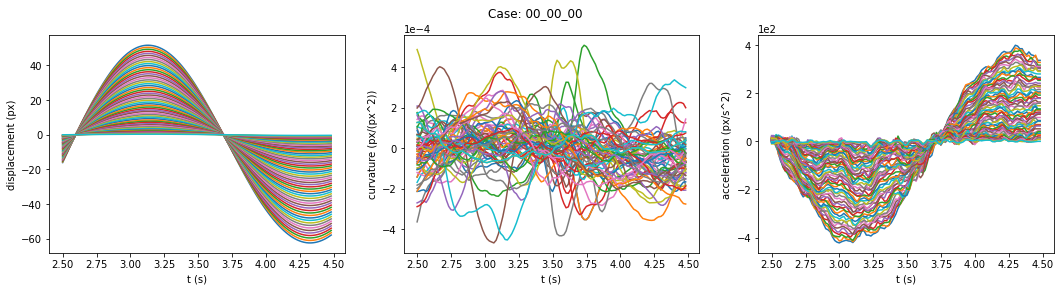

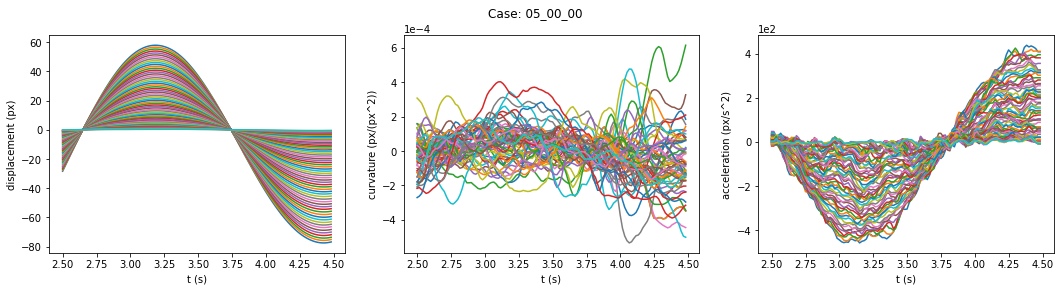

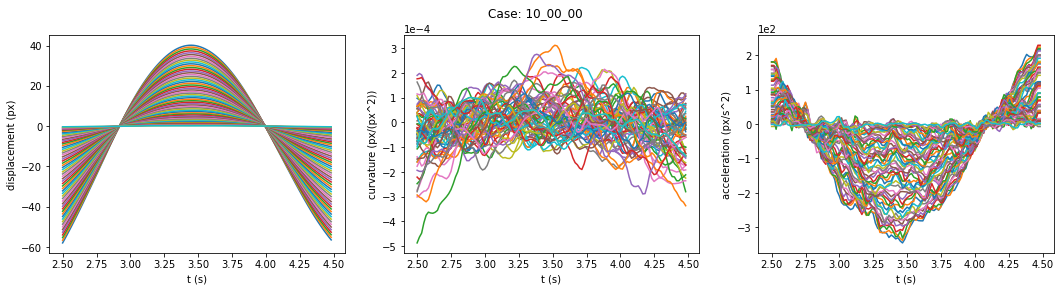

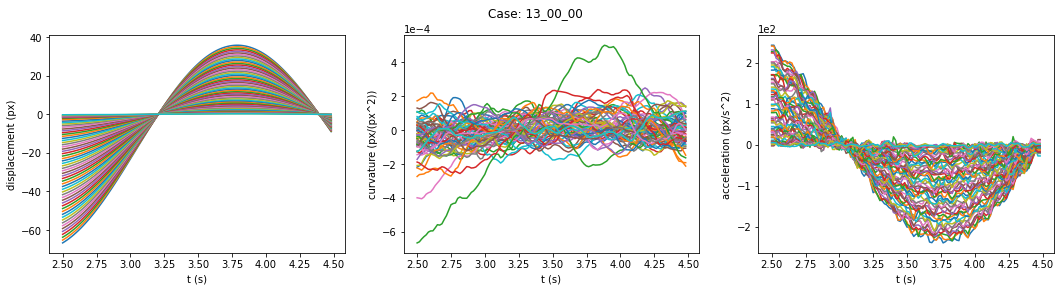

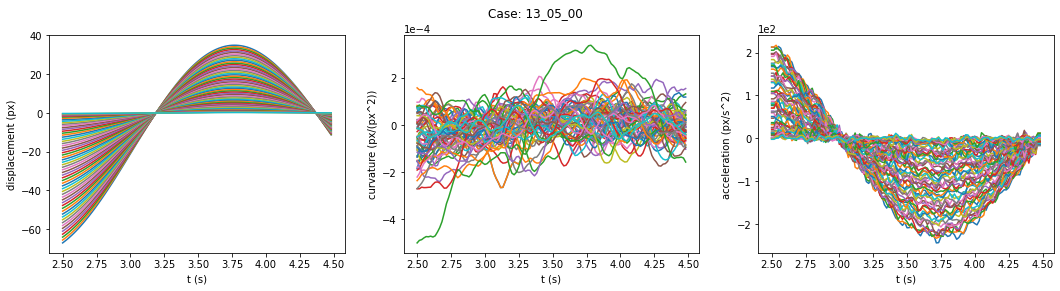

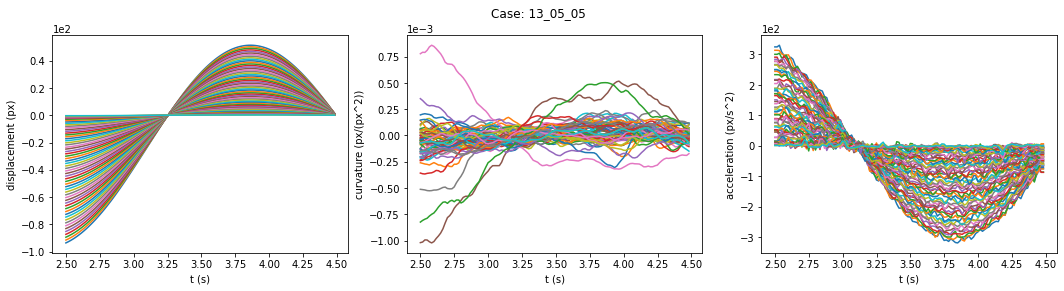

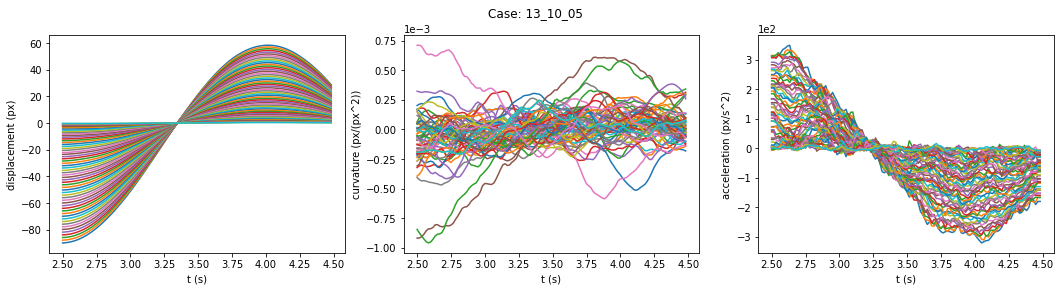

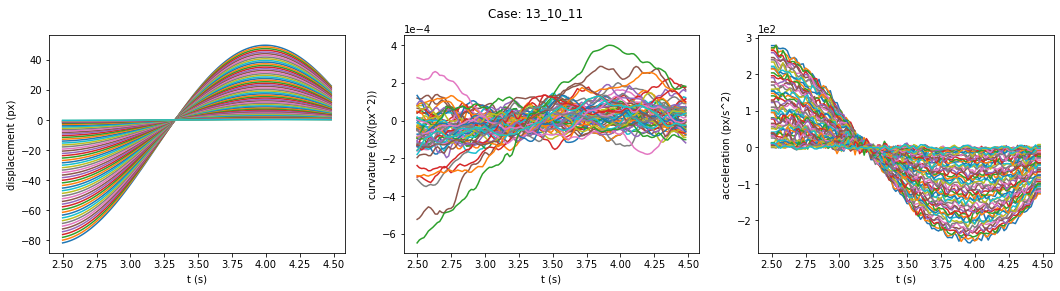

In [13]:
fig_size = (18,4)
for th in ths:
  fig, ax = plt.subplots(1,3, sharey=False, figsize=fig_size)
  fig.suptitle(f'Case: {th._name[0:-5]}')
  # ax[0].plot(th.x, th.C)
  # ax[0].set_xlabel('x (px)')
  # ax[0].set_ylabel('curvature (px/(px^2))')
  ax[0].plot(th.t.T, th.D.T)
  ax[0].set_xlabel('t (s)')
  ax[0].set_ylabel('displacement (px)')  
  ax[0].ticklabel_format(axis='y', scilimits=[-2, 2])
  ax[1].plot(th.t.T, th.C.T)
  ax[1].set_xlabel('t (s)')
  ax[1].set_ylabel('curvature (px/(px^2))')
  ax[1].ticklabel_format(axis='y', scilimits=[-2, 2])
  ax[2].plot(th.t.T, th.A.T)
  ax[2].set_xlabel('t (s)')
  ax[2].set_ylabel('acceleration (px/s^2)')  
  ax[2].ticklabel_format(axis='y', scilimits=[-2, 2])
  plt.show

# Pre-processing

## Detect the time instant of minimum and maximum rms curvature

### Extraction of intantaneous curvatures and accelerations

In [14]:
neg_pos = -1
max_curv_lim = 0
cases = {}
for th in ths:
  rms_accel = np.sqrt(np.mean(th.A**2, axis=0))
  rms_curv = np.sqrt(np.mean(th.C**2, axis=0))
  mean_curv = np.mean(th.C, axis=0)
  abs_mean_curv = np.abs(np.mean(th.C, axis=0))
  rms_disp = np.sqrt(np.mean(th.D**2, axis=0))
  peak_curv = np.max(np.abs(th.C), axis=0)
  peak_disp = np.max(np.abs(th.D), axis=0)
  max_curv_ind, min_curv_ind = np.argmax(rms_disp), np.argmin(rms_disp)
  if np.max(np.max(np.abs(th.C))) > max_curv_lim:
    max_curv_lim = np.max(np.max(np.abs(th.C)))
  cases[th._name] = \
    {'min_curv': {'x': th.x, 'C': th.C[:,min_curv_ind], 
                  'S': th.S[:,min_curv_ind], 'D': th.D[:,min_curv_ind], 
                  'D_': th.D_[:,min_curv_ind], 'A': th.A[:,min_curv_ind]},
     'min_curv_rms': rms_curv[min_curv_ind],
     'min_curv_disp_rms': np.sqrt(np.mean(th.D[:,min_curv_ind]**2, axis=0)),
     'max_curv': {'x': th.x, 
                  'C': th.C[:,max_curv_ind],
                  'logC': np.log(neg_pos*th.C[:,max_curv_ind]), 
                  'S': th.S[:,max_curv_ind], 
                  'D': th.D[:,max_curv_ind], 
                  'D_': th.D_[:,max_curv_ind], 
                  'A': th.A[:,max_curv_ind]},
     'max_curv_rms': rms_curv[max_curv_ind],
     'max_curv_disp_rms': np.sqrt(np.mean(th.D[:,max_curv_ind]**2, axis=0)),
     'max_curv_median': {'x': th.x, 'C': 
                         scipy.ndimage.median_filter(th.C[:,max_curv_ind], 
                                                     size=ip.L_ch, 
                                                     mode='mirror')}}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


### Plot curvatures and accelerations

In [29]:
len(cases)

8

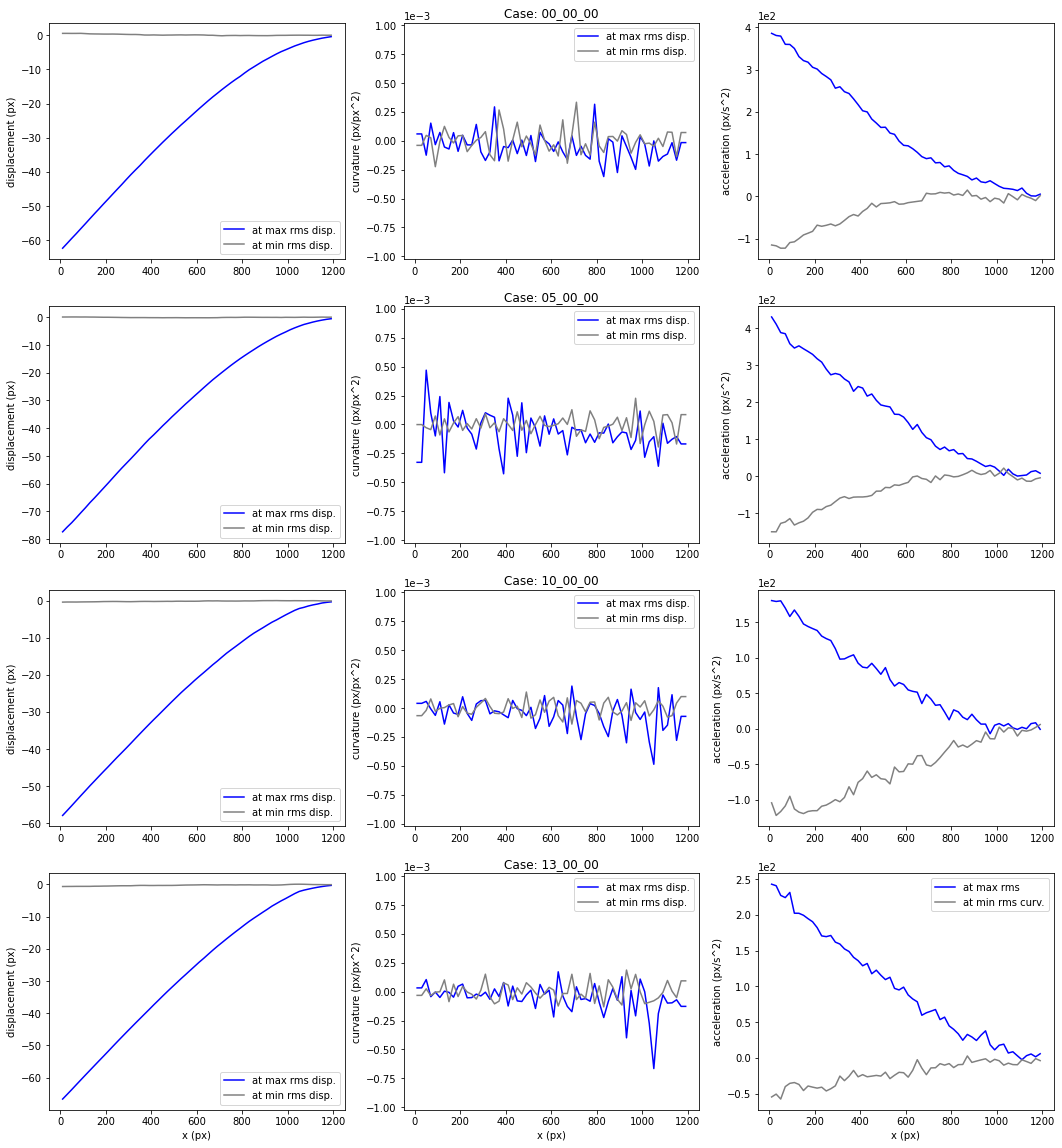

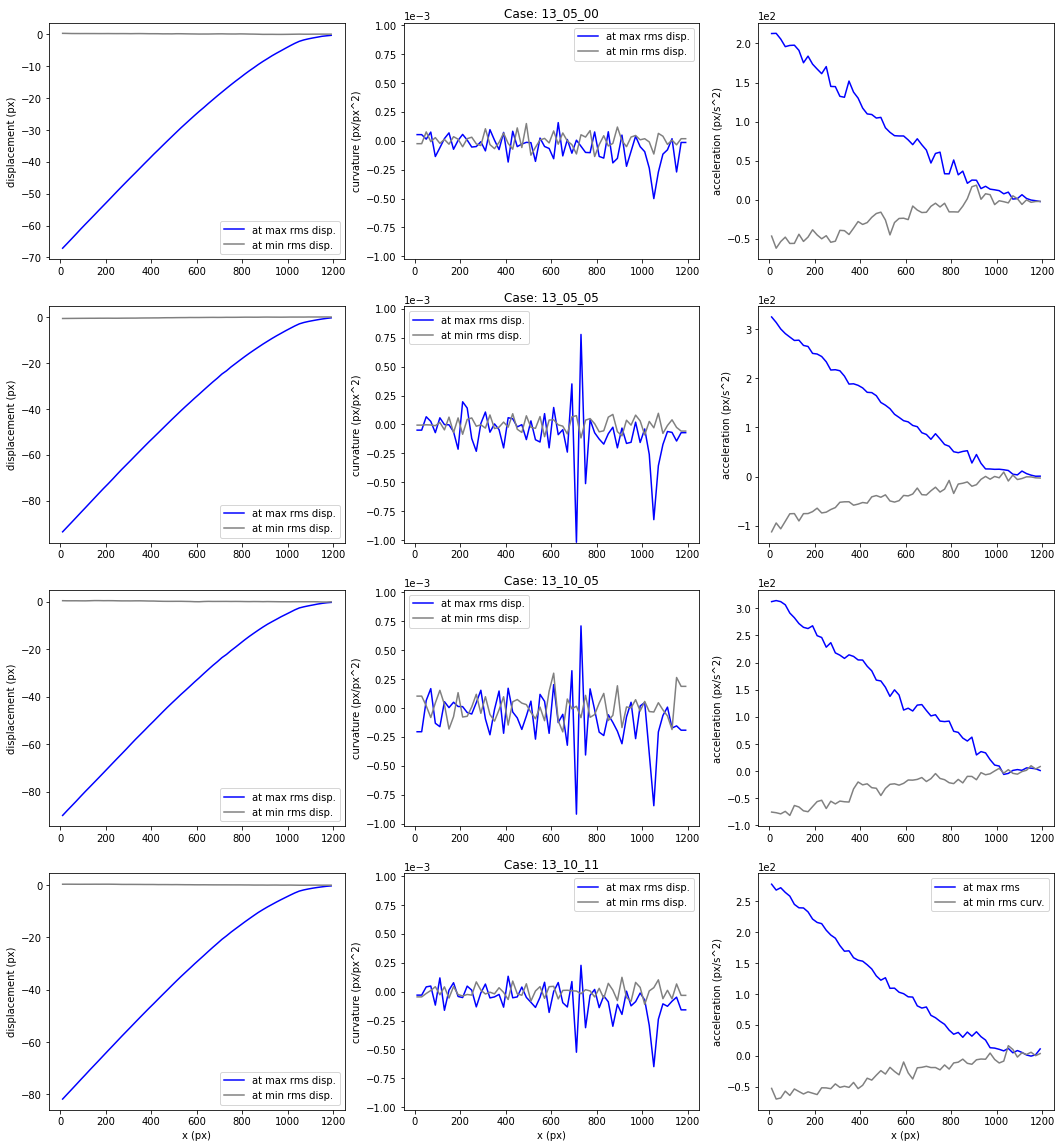

In [46]:
fig_size = (18, 20)
figs = []
for i_fig in [0, 1]:
  fig, axs = plt.subplots(len(cases)//2, 3, figsize=fig_size)
  figs.append(fig)  
  for i, key in enumerate(list(cases.keys())[0+(len(cases)//2)*(i_fig):(len(cases)//2)*(i_fig+1)]):
    axs[i, 1].set_title(f"Case: {key[0:-5]}")
    axs[i, 0].set_ylabel('displacement (px)') 
    axs[i, 0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['D'],
                color='blue', label='at max rms disp.')
    axs[i, 0].plot(cases[key]['min_curv']['x'], cases[key]['min_curv']['D'],
                color='gray', label='at min rms disp.')
    axs[i, 0].ticklabel_format(axis='y', scilimits=[-2, 2]) 
    axs[i, 0].legend() 

    axs[i, 1].set_ylabel('curvature (px/px^2)')
    axs[i, 1].set_ylim((-max_curv_lim, max_curv_lim))
    axs[i, 1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C'],
                color='blue', label='at max rms disp.')
    axs[i, 1].plot(cases[key]['min_curv']['x'], cases[key]['min_curv']['C'],
                color='gray', label='at min rms disp.')  
    axs[i, 1].ticklabel_format(axis='y', scilimits=[-2, 2]) 
    axs[i, 1].legend()

    axs[i, 2].set_ylabel('acceleration (px/s^2)') 
    axs[i, 2].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['A'],
                color='blue', label='at max rms')
    axs[i, 2].plot(cases[key]['min_curv']['x'], cases[key]['min_curv']['A'],
                color='gray', label='at min rms curv.')    
    axs[i, 2].ticklabel_format(axis='y', scilimits=[-2, 2]) 
  axs[i, 2].legend()
  axs[i, 0].set_xlabel('x (px)') 
  axs[i, 1].set_xlabel('x (px)')
  axs[i, 2].set_xlabel('x (px)')
  plt.show()

## Sinthesys of healthy structure model response, using meassured curvature

In [16]:
neg_pos = -1
for key in cases.keys():
  c_h, m_, m, res_x = hsmr.synthesis(
      c=cases[key]['max_curv']['C'], 
      q=cases[key]['max_curv']['A'], dyn_stiff_initial_guess=10, dyn_stiff_min=1, m_0_max=0)
  # bending moment with null integration constants
  cases[key]['max_curv'].update({'M_': m_})
  # bending moment with apropriate integration constants and dynamic stiffness
  cases[key]['max_curv'].update({'M': m})  
  # healthy curvature
  cases[key]['max_curv'].update({'C_h': c_h})

  # construction of noisy healthy curvature
  cases[key]['max_curv'].update({'C_h_noisy': cases[key]['max_curv']['C_h']
                                 + cases[key]['min_curv']['C']}) 

## Generation of actual damage reference

In [17]:
for key in cases.keys():
  crack_depths_mm = 3*[0]
  crack_depths_mm[0] = float(key[0:2])
  crack_depths_mm[1] = float(key[3:5])
  crack_depths_mm[2] = float(key[6:8])
  x = ths[0].x
  H_EI_actual = np.ones(len(x))
  for crack_loc_px, crack_depth_mm in zip(ip.crack_locs_px, crack_depths_mm):
    crack_loc_ind = np.argmin(abs(x - crack_loc_px))
    H_EI_d = (1 - (crack_depth_mm/ip.h_s_mm))**3
    h_d_px = ip.h_d *(x[1]-x[0])
    slope = (1-H_EI_d)/h_d_px
    for i in range(crack_loc_ind, crack_loc_ind+ip.h_d):
      H_EI_actual[i] = H_EI_d + slope*(x[i] - crack_loc_px)
    for i in range(crack_loc_ind-ip.h_d+1, crack_loc_ind):
      H_EI_actual[i] = H_EI_d - slope*(x[i] - crack_loc_px)      
    H_EI_actual[crack_loc_ind] = H_EI_d
  cases[key].update({'H_EI': {'x': cases[key]['max_curv']['x'],
                              'H_EI_actual': H_EI_actual}})
  

## Statistical analysis

### Scan of points with a window

In [18]:
half_length_window = ip.h_d
n_points = len(cases[key]['max_curv']['C'])
window_shape = scipy.signal.windows.gaussian(2*half_length_window+1, 
                                             half_length_window/3) # 3stds
window_shape = window_shape * (2*half_length_window+1) / np.sum(window_shape)
for key in cases.keys():
  window_healthy, window_test = [], []
  for i in range(n_points):
    if half_length_window <= i < n_points-half_length_window:
      window_slice = \
      [i for i in range(i-half_length_window, i+half_length_window+1)]
    elif i < half_length_window:
      window_slice = [i for i in range(0,2*half_length_window+1)]
    else:
      window_slice = [i for i in range(n_points-2*half_length_window-1, n_points)]
    window_healthy.append(cases[key]['max_curv']['C_h_noisy'][window_slice]\
                          * window_shape)
    window_test.append(cases[key]['max_curv']['C'][window_slice]\
                       * window_shape)
  cases[key]['max_curv'].update({'window_healthy': window_healthy,
                                 'window_test': window_test})


### Calculation of mean, variance and covariance

In [19]:
for key in cases.keys():
  # global covariance matrix
  mat = np.vstack([cases[key]['max_curv']['C_h_noisy'],
                   cases[key]['max_curv']['C']])
  cases[key]['max_curv']['global_cov_mat'] = np.cov(mat)
  cases[key]['max_curv']['global_var_healthy'] = cases[key]['max_curv']['global_cov_mat'][0,0]*np.ones(n_points)
  cases[key]['max_curv']['global_var_test'] = cases[key]['max_curv']['global_cov_mat'][1,1]*np.ones(n_points)
  cases[key]['max_curv']['global_covar_test_healthy'] = cases[key]['max_curv']['global_cov_mat'][0,1]*np.ones(n_points)
  # window covariance matrices
  cases[key]['max_curv']['cov_mat'] = n_points*[None]
  cases[key]['max_curv']['var_healthy'] = np.zeros(n_points)
  cases[key]['max_curv']['var_test'] = np.zeros(n_points)
  cases[key]['max_curv']['covar_test_healthy'] = np.zeros(n_points)
  cases[key]['max_curv']['mean_healthy'] = np.zeros(n_points) 
  cases[key]['max_curv']['mean_test'] = np.zeros(n_points)
  for i in range(n_points):
    # cases[key]['max_curv']['mean_healthy'][i] = np.mean(cases[key]['max_curv']['window_healthy'][i])
    cases[key]['max_curv']['mean_healthy'][i] = cases[key]['max_curv']['C_h'][i]
    cases[key]['max_curv']['mean_test'][i] = np.mean(cases[key]['max_curv']['window_test'][i])
    mat = np.vstack([cases[key]['max_curv']['window_healthy'][i],
                     cases[key]['max_curv']['window_test'][i]])
    cases[key]['max_curv']['cov_mat'][i] = np.cov(mat)
    cases[key]['max_curv']['var_healthy'][i] = cases[key]['max_curv']['cov_mat'][i][0,0]
    cases[key]['max_curv']['var_test'][i] = cases[key]['max_curv']['cov_mat'][i][1,1]
    cases[key]['max_curv']['covar_test_healthy'][i] = cases[key]['max_curv']['cov_mat'][i][0,1]


### Calculation of strictly standarized mean, damage localization and damage quantification

In [20]:
threshold = 0.25
for key in cases.keys():
  # SSMD from window covariance
  mu_1 = cases[key]['max_curv']['mean_test']
  mu_2 = cases[key]['max_curv']['mean_healthy']
  sigma2_1 = cases[key]['max_curv']['var_test']
  sigma2_2 = cases[key]['max_curv']['var_healthy']
  sigma_12 = cases[key]['max_curv']['covar_test_healthy']
  cases[key]['max_curv']['MD'] = mu_1 - mu_2
  cases[key]['max_curv']['SSMD'] = (mu_1 - mu_2) / \
    np.sqrt(sigma2_1 + sigma2_2 - 2*sigma_12)
  # damage quantification
  cases[key]['H_EI'].update({'H_EI': mu_2 / mu_1,
                             'H_EI_loc': mu_2 / mu_1,
                             'H_EI_raw': cases[key]['max_curv']['C_h']/cases[key]['max_curv']['C'],
                             'H_EI_raw_loc': cases[key]['max_curv']['C_h']/cases[key]['max_curv']['C']})
  # damage localization 
  for i in range(n_points):
    if i < half_length_window or i >= n_points-half_length_window:
      cases[key]['H_EI']['H_EI_raw'][i] = np.nan
      cases[key]['H_EI']['H_EI_raw_loc'][i] = np.nan
      cases[key]['H_EI']['H_EI'][i] = np.nan
      cases[key]['H_EI']['H_EI_loc'][i] = np.nan
      cases[key]['max_curv']['MD'][i] = np.nan
      cases[key]['max_curv']['SSMD'][i] = np.nan
      cases[key]['max_curv']['mean_test'][i] = np.nan
      cases[key]['max_curv']['mean_healthy'][i] = np.nan
      cases[key]['max_curv']['var_test'][i] = np.nan
      cases[key]['max_curv']['var_healthy'][i] = np.nan
      cases[key]['max_curv']['covar_test_healthy'][i] = np.nan
    if cases[key]['max_curv']['SSMD'][i] > -threshold:
      cases[key]['H_EI']['H_EI_loc'][i] = np.nan
      cases[key]['H_EI']['H_EI_raw_loc'][i] = np.nan
   
    

### Plot of instantaneous curvature and damage identification

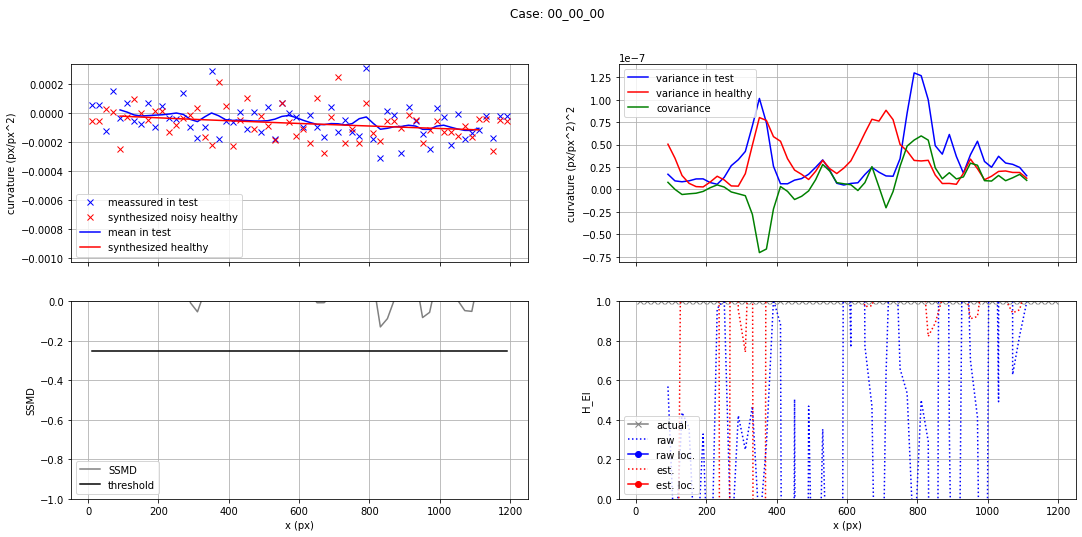

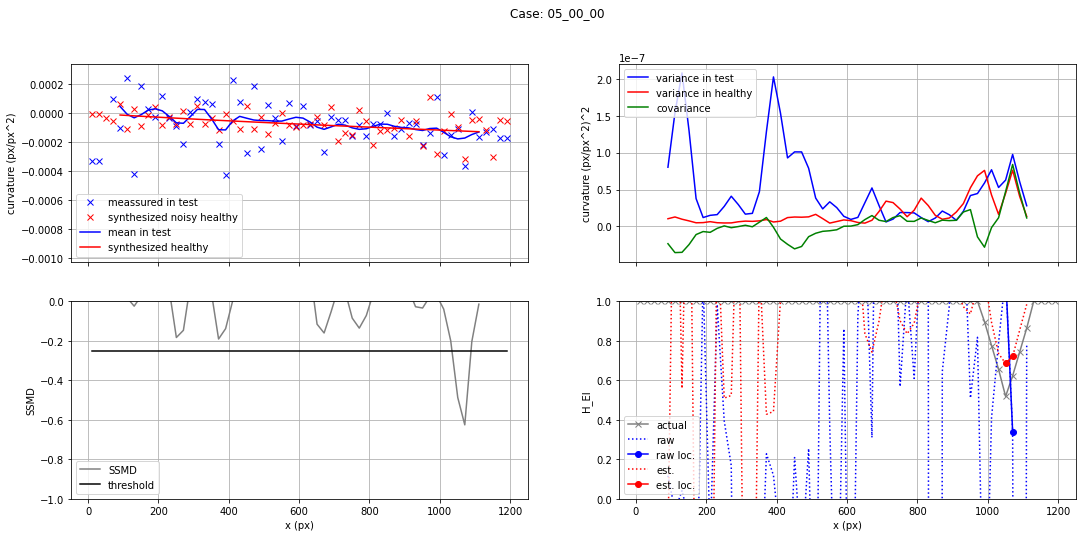

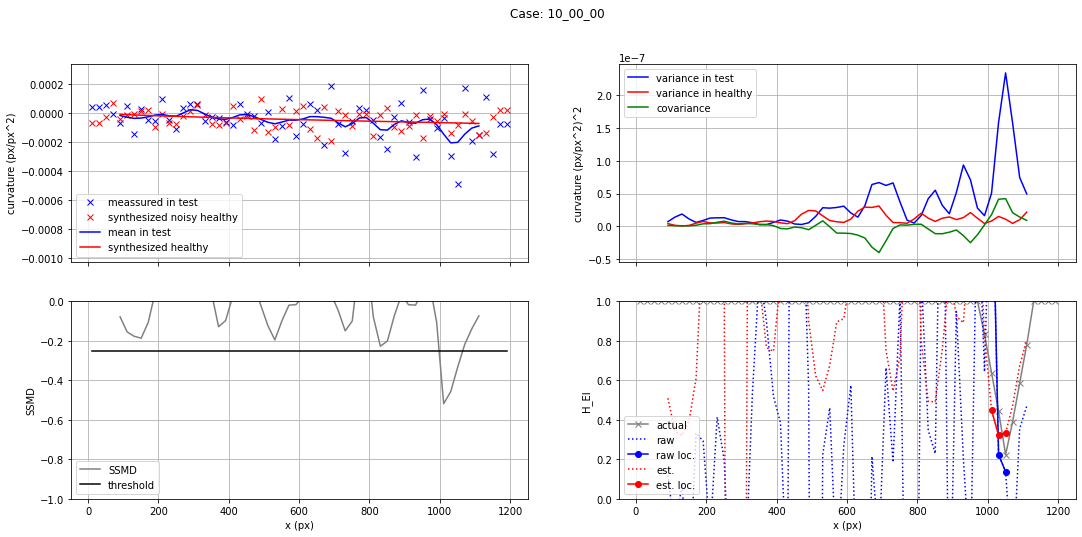

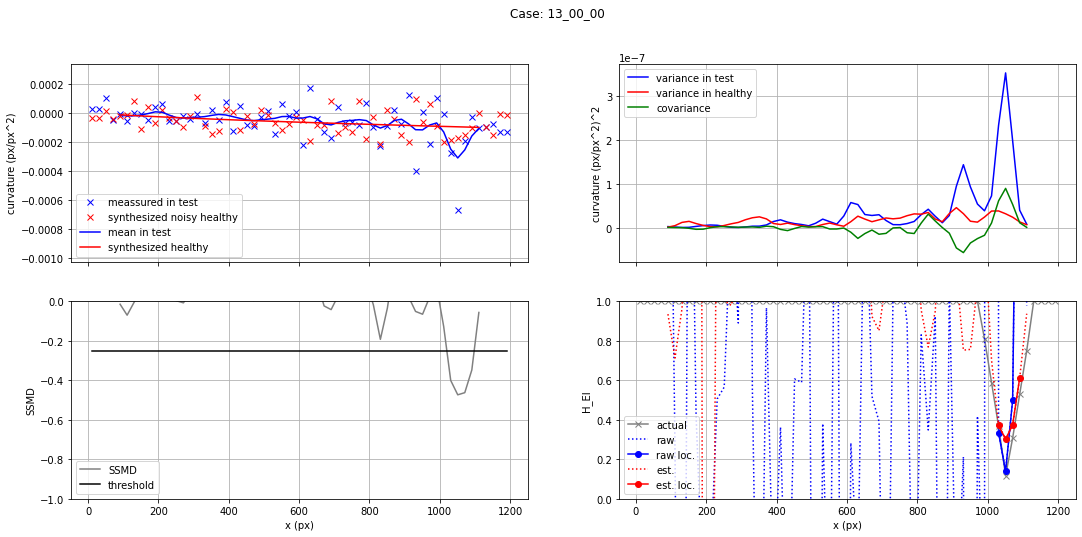

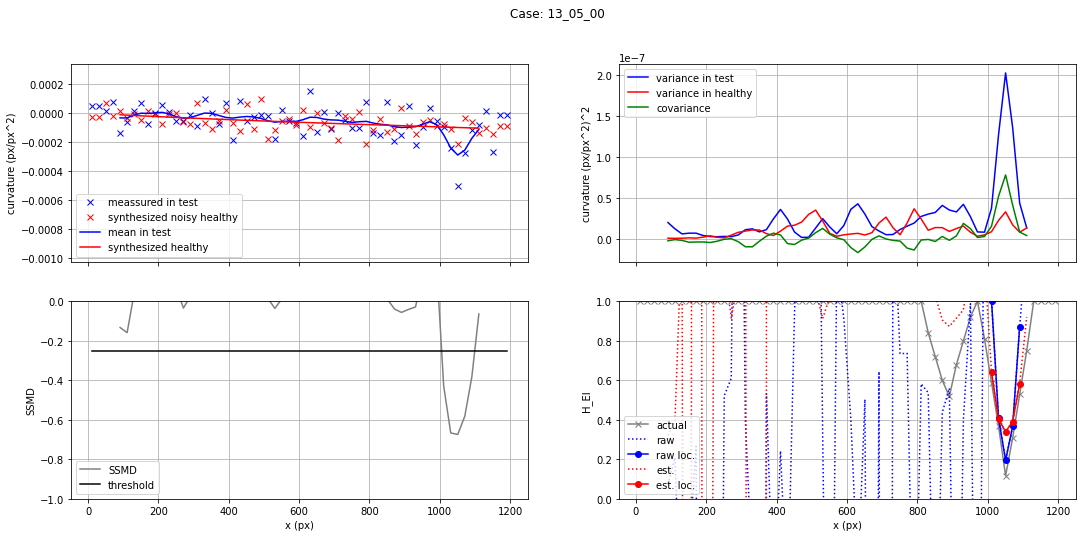

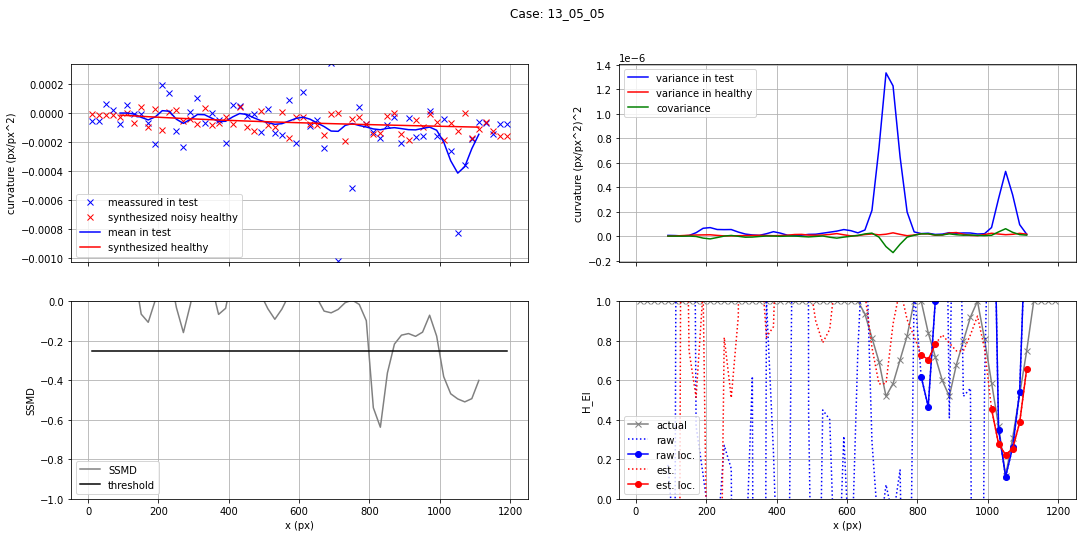

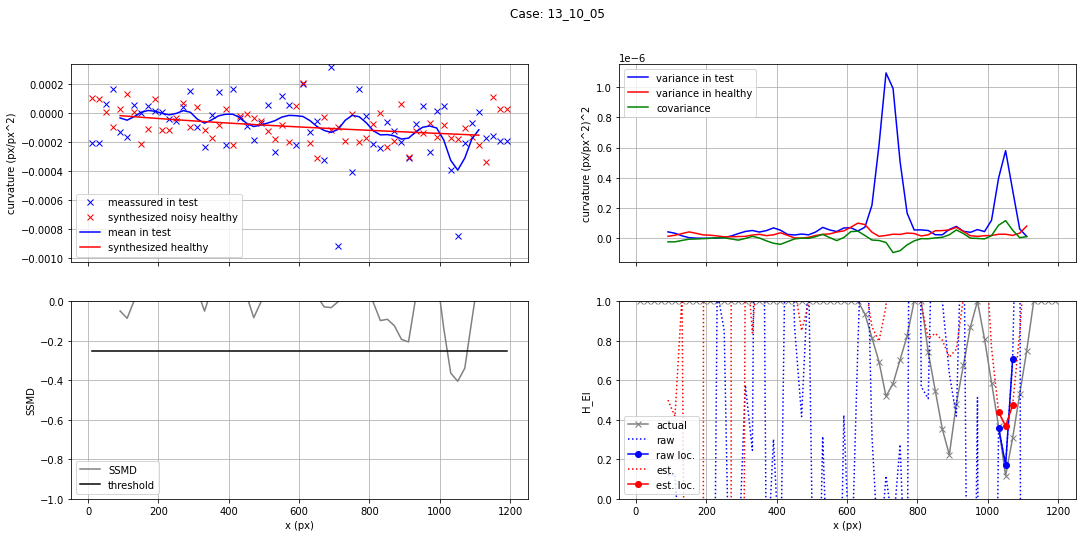

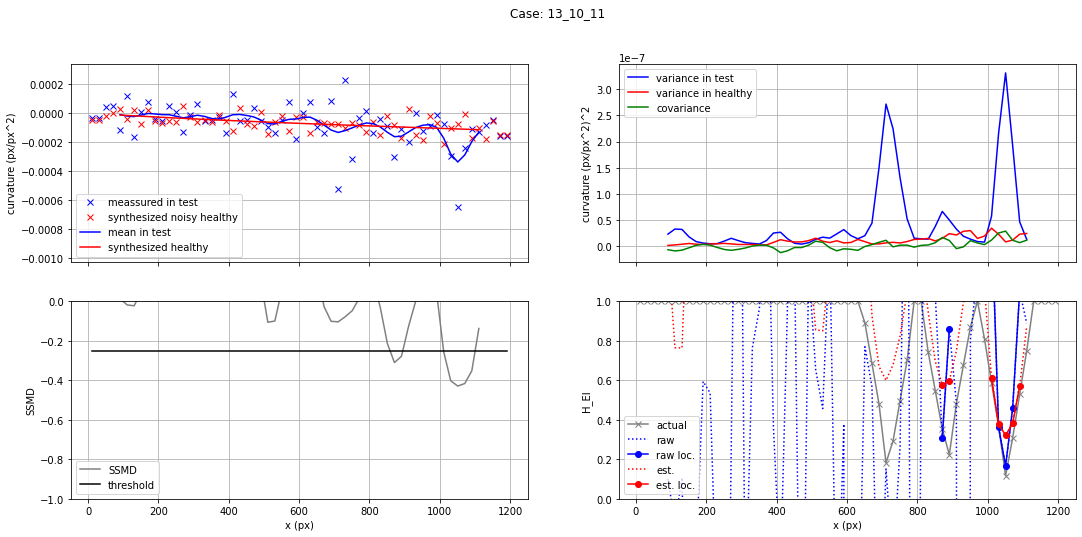

In [43]:
fig_size = (18, 8)
path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field time-domain'
plt.show()
for key in cases.keys():
  fig, axs = plt.subplots(2,2, figsize=fig_size, sharex=True)
  fig.suptitle(f"Case: {key[0:-5]}")  
  axs[0,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C'],
                color='blue', marker='x', linestyle='', label='meassured in test')
  axs[0,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C_h_noisy'],
                color='red', marker='x', linestyle='', label='synthesized noisy healthy')   
  axs[0,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['mean_test'],
                color='blue', marker='', linestyle='-', label='mean in test')   
  axs[0,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['mean_healthy'],
                color='red', marker='', linestyle='-', label='synthesized healthy')   
  axs[0,0].set_ylim((-max_curv_lim, max_curv_lim/3))
  axs[0,0].set_ylabel('curvature (px/px^2)')
  # axs[0,0].set_xlabel('x (px)')
  axs[0,0].legend(loc='lower left')
  axs[0,0].grid(True)
  axs[0,1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['var_test'],
              color='blue', label='variance in test')
  axs[0,1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['var_healthy'],
              color='red', label='variance in healthy') 
  axs[0,1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['covar_test_healthy'],
              color='green', label='covariance')   
  # axs[0,1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['global_var_test'],
  #             color='blue', linestyle='--', label='curv. global variance in test')
  # axs[0,1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['global_var_healthy'],
  #             color='red', linestyle='--', label='curv. global variance in healthy') 
  # axs[0,1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['global_covar_test_healthy'],
  #             color='green', linestyle='--', label='global covariance')   
  axs[0,1].set_ylabel('curvature (px/px^2)^2')
  # axs[0,1].set_xlabel('x (px)')
  axs[0,1].legend(loc='upper left')
  axs[0,1].grid(True) 

  axs[1,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['SSMD'],
            color='gray', label='SSMD') 
  axs[1,0].plot(cases[key]['max_curv']['x'], neg_pos*threshold*np.ones(n_points),
            color='black', label='threshold') 
  # axs[1,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['global_SSMD'],
  #           color='blue', label='global_SSMD') 
  axs[1,0].set_ylabel('SSMD')
  axs[1,0].set_xlabel('x (px)')
  axs[1,0].legend(loc='lower left')
  axs[1,0].set_ylim((-1,0))  
  axs[1,0].grid(True)

  axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI_actual'],
            color='gray', label='actual', marker='x', linestyle='-')   
  axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI_raw'],
            color='blue', label='raw', linestyle=':')  
  axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI_raw_loc'],
            color='blue', label='raw loc.', marker='o', linestyle='-')  
  axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI'],
            color='red', label='est.', linestyle=':')  
  axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI_loc'],
            color='red', label='est. loc.', marker='o', linestyle='-')    
  # axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['global_H_EI'],
  #           color='blue', label='global_H_EI', linestyle=':')  
  # axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['global_H_EI_loc'],
  #           color='blue', label='global_H_EI_loc', marker='o', linestyle='-')   
  axs[1,1].set_ylabel('H_EI')
  axs[1,1].set_xlabel('x (px)')
  axs[1,1].legend(loc='lower left')
  axs[1,1].set_ylim((0, 1))  
  axs[1,1].grid(True)
  plt.savefig(os.path.join(path, f'{key}.pdf'))
  plt.show()


In [27]:
50 *100/90


55.55555555555556

In [26]:
3+(8/7) - (29/7)

-8.881784197001252e-16